In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re

from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.stem import PorterStemmer

from wordcloud import WordCloud 

## Load data

In [4]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']] 

In [5]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum() 

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
train_data.duplicated().sum()

1

In [9]:
train_data.drop_duplicates(inplace=True)
print(train_data.duplicated().sum())

0


# EDA

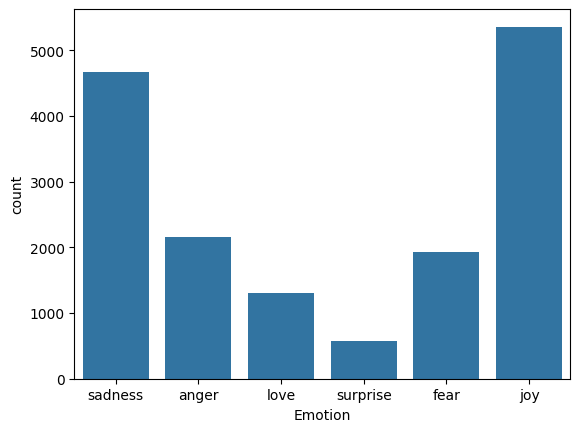

In [10]:
sns.countplot(x = train_data['Emotion'])
plt.show() 

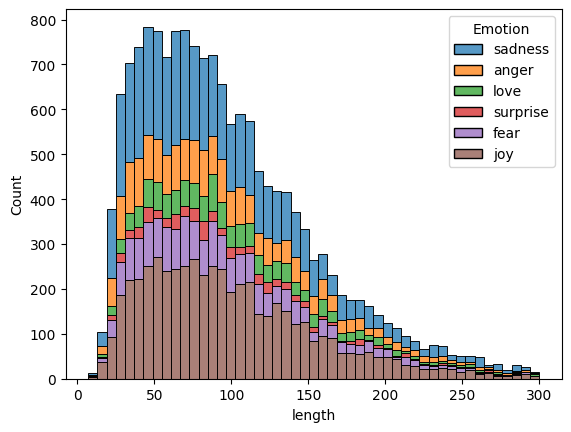

In [11]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show() 

In [12]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

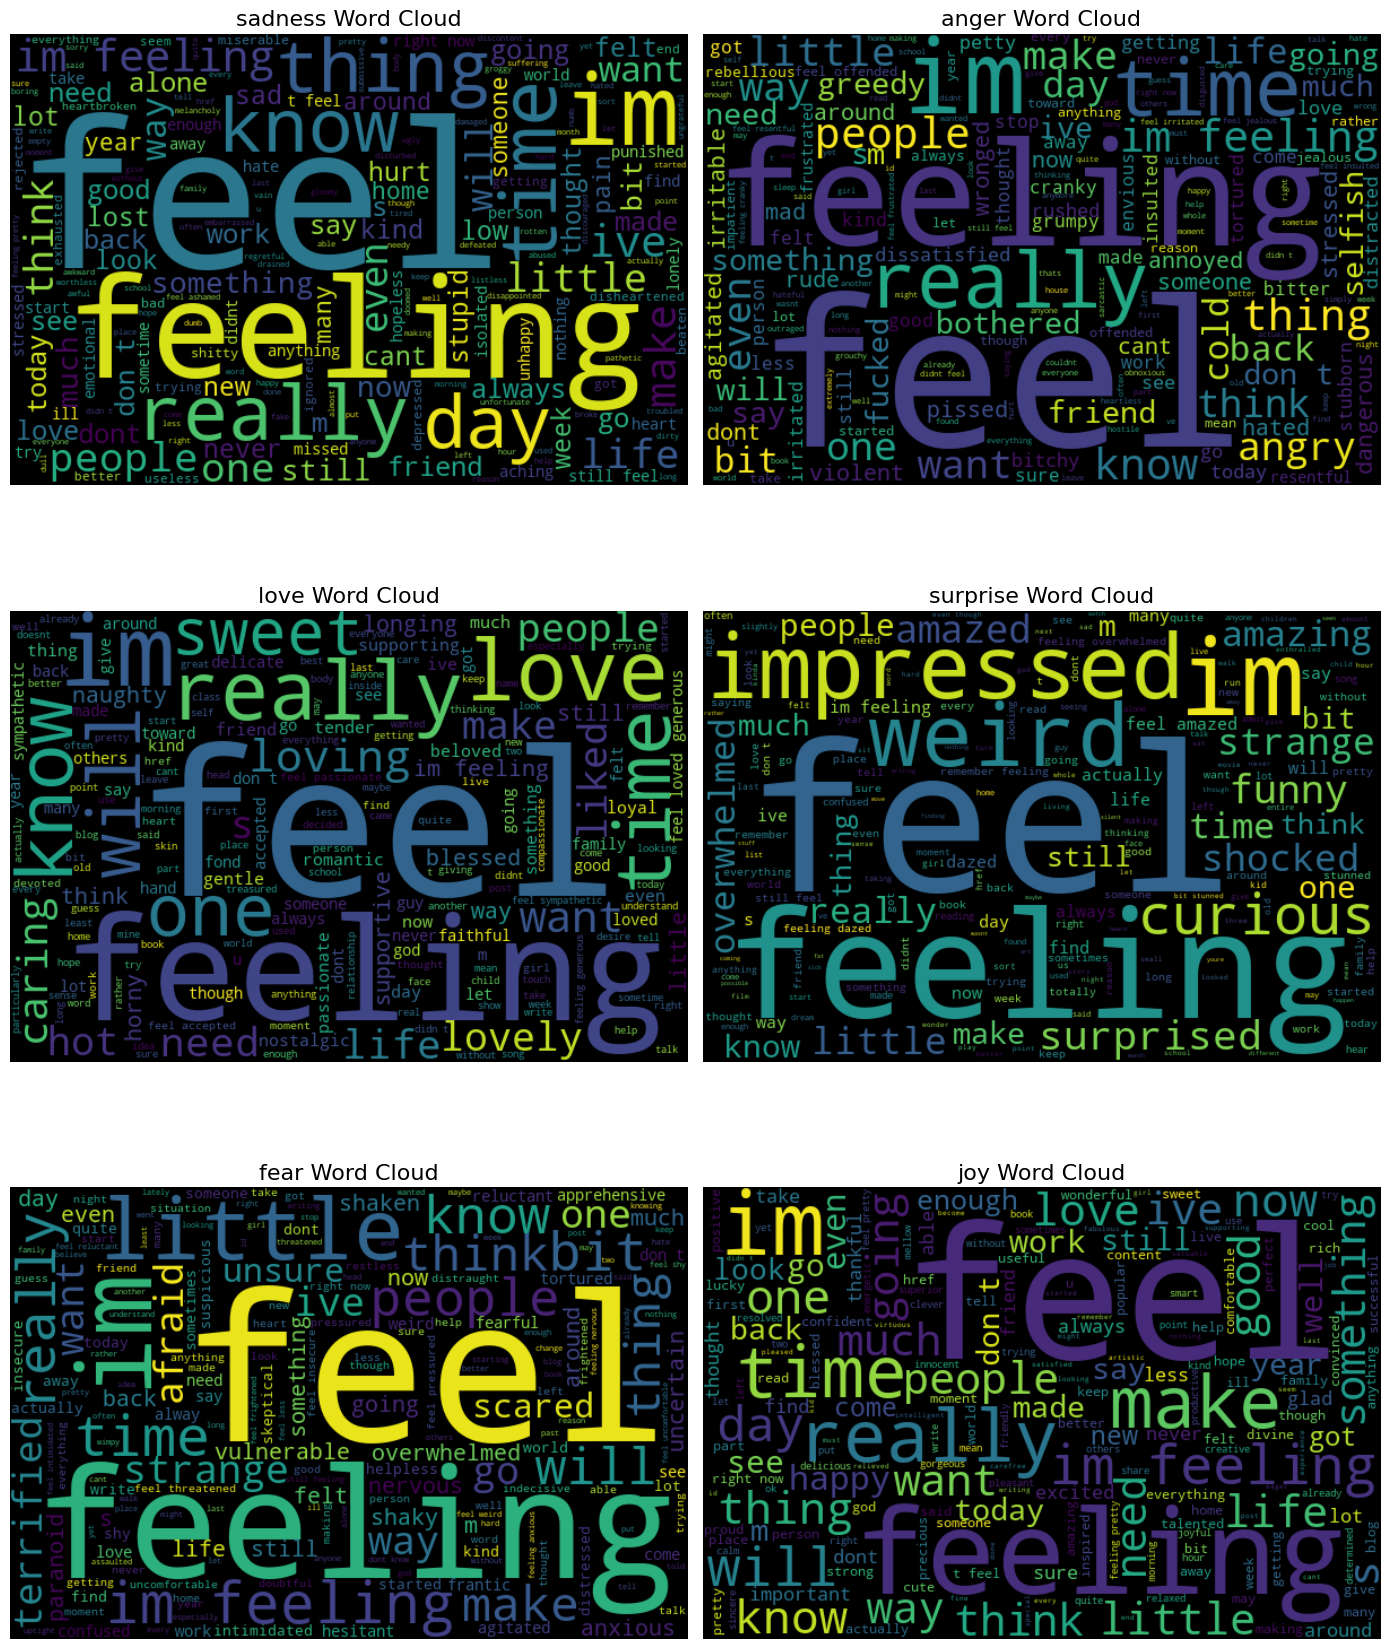

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 cols
axes = axes.flatten()  

for i, emotion in enumerate(emotions_list):
    text = ' '.join(train_data.loc[train_data['Emotion'] == emotion, 'Comment'].astype(str))

    wordcloud = WordCloud(width=600, height=400, background_color='black').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(str(emotion) + ' Word Cloud', fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

### Encode emotions

In [14]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [15]:
for label,emotion in enumerate(lb.classes_):
    print(label," -> ", emotion)

0  ->  anger
1  ->  fear
2  ->  joy
3  ->  love
4  ->  sadness
5  ->  surprise


In [16]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


## Applying Machine Learning

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report 

In [18]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [19]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [20]:
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42) 

In [22]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test) 

In [23]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf)) 


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====


d:\c_ML\Project\ml-env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy using TF-IDF: 0.8240625
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.46      0.59       303
           4       0.88      0.92      0.90       950
           5       0.74      0.46      0.57       106

    accuracy                           0.82      3200
   macro avg       0.82      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200


===== Random Forest =====

Accuracy using TF-IDF: 0.8471875
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       439
           1       0.82      0.84      0.83       375
           2       0.84      0.90      0.87      1027
           3       0.82      0.59      0.69       303
           4       0.91      0.88      0.90  

In [24]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

d:\c_ML\Project\ml-env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Actual :",label)
    print("================================================================") 

i didnt feel humiliated
Prediction : sadness
Actual : 4
i feel strong and good overall
Prediction : joy
Actual : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Actual : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Actual : 2
This is outrageous, how can you talk like that?
Prediction : anger
Actual : 0
I feel like im all alone in this world
Prediction : sadness
Actual : 4
He is really sweet and caring
Prediction : love
Actual : 3
You made me very crazy
Prediction : sadness
Actual : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Actual : 3
i am feeling grouchy
Prediction : anger
Actual : 0
He hates you
Prediction : anger
Actual : 0


In [26]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb')) 
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [27]:
import sklearn
print(sklearn.__version__) # use this version in pycharm 

1.3.2


## Applying Deep learning Using LSTM

### Text Cleaning, Ecoding, and Padding

In [28]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
# from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [29]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    # one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    # pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(corpus)

    seqs = tokenizer.texts_to_sequences(corpus)
    pad = pad_sequences(seqs, maxlen=max_len, padding='pre')
    return pad,tokenizer

# Text cleaning and encoding
x_train,tokenizer = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

# Model Building and Training

In [30]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback]) 

Epoch 1/10
250/250 [==============================] - 221s 875ms/step - loss: 1.3763 - accuracy: 0.4687
Epoch 2/10
250/250 [==============================] - 322s 1s/step - loss: 0.5415 - accuracy: 0.8233
Epoch 3/10
250/250 [==============================] - 355s 1s/step - loss: 0.2397 - accuracy: 0.9205
Epoch 4/10
250/250 [==============================] - 296s 1s/step - loss: 0.1586 - accuracy: 0.9486
Epoch 5/10
250/250 [==============================] - 292s 1s/step - loss: 0.1163 - accuracy: 0.9627
Epoch 6/10
250/250 [==============================] - 287s 1s/step - loss: 0.0981 - accuracy: 0.9668
Epoch 7/10
250/250 [==============================] - 269s 1s/step - loss: 0.0775 - accuracy: 0.9729
Epoch 8/10
250/250 [==============================] - 261s 1s/step - loss: 0.0683 - accuracy: 0.9767
Epoch 9/10
250/250 [==============================] - 298s 1s/step - loss: 0.0560 - accuracy: 0.9803
Epoch 10/10
250/250 [==============================] - 310s 1s/step - loss: 0.0495 - acc

## Predictive System

In [31]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    seqs = tokenizer.texts_to_sequences(corpus)
    pad = pad_sequences(seqs, maxlen=300, padding='pre')

    return pad

In [32]:
sentences = [
    "i feel strong and good overall",
    "i'm grabbing a minute to post i feel greedy wrong",
    "He was speechles when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like i'm all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
    "i am feeling grouchy",
    "He hates you"
]

for s in sentences:
    print(s)
    x = sentence_cleaning(s)
    preds = model.predict(x)        # shape (1, n_classes)
    label_idx = np.argmax(preds, axis=1)   # array([idx])
    proba = preds.max()                    # highest probability
    emotion = lb.inverse_transform(label_idx)[0]  # string label
    print(f"{emotion} : {proba:.4f}\n")


i feel strong and good overall
1/1 [==============================] - 1s 977ms/step
joy : 0.9995

i'm grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 48ms/step
anger : 0.9989

He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 57ms/step
love : 0.4840

This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 63ms/step
anger : 0.9827

I feel like i'm all alone in this world
1/1 [==============================] - 0s 39ms/step
sadness : 0.9871

He is really sweet and caring
1/1 [==============================] - 0s 65ms/step
love : 0.9622

You made me very crazy
1/1 [==============================] - 0s 45ms/step
sadness : 0.4562

i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 59ms/step
love : 0.9960

i am feeling grouchy
1/1 [==============================] - 0s 50ms/step
a

# Save the model and files

In [33]:

model.save('model1.keras')

with open("tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer,f)

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f) 

In [34]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.13.1
2.13.0
